<a href="https://colab.research.google.com/github/alina-bogdanovskaya/PyTorch_Jan2023/blob/lesson2/Copy_of_HW_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10

train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                              train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True, 
                                           num_workers=2)

Files already downloaded and verified


In [3]:
classes = train_dataset.classes

In [4]:
test_dataset = torchvision.datasets.CIFAR100(root='data/',
                                             train=False, 
                                             transform=transforms.ToTensor(), 
                                             download=True)

test_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size=8, 
                                          shuffle=True,
                                          num_workers=2)

Files already downloaded and verified


In [5]:
image, label = train_dataset[0]
image.size()

torch.Size([3, 32, 32])

In [6]:
input = 3 * 32 * 32
output = len(train_dataset.classes)

In [7]:
def show_batch(dl):
    for batch in dl:
        images,labels = batch
        fig, ax = plt.subplots(figsize=(7.5, 7.5))
        ax.set_yticks([])
        ax.set_xticks([])
        ax.imshow(make_grid(images[:20], nrow=4).permute(1,2,0))
        break

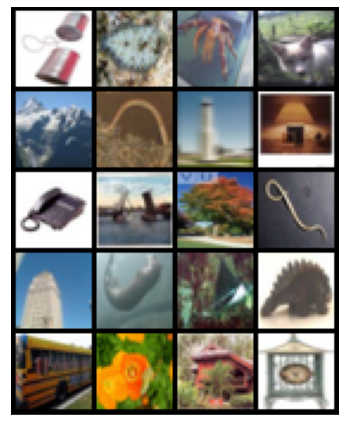

In [8]:
show_batch(train_loader)

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class ToDeviceLoader:
    def __init__(self, data, device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch, self.device)
            
    def __len__(self):
        return len(self.data)

In [10]:
device = get_device()
print(device)

train_data = ToDeviceLoader(train_loader, device)
test_data = ToDeviceLoader(test_loader, device)

cuda


In [11]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class BaseModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
       
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch}, train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

In [14]:
class Net(BaseModel):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 8 * hidden_dim)
        self.fc2 = nn.Linear(8 * hidden_dim, 4 * hidden_dim)
        self.fc3 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc4 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc5(x)
        return x

    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc4(x)
        x = F.leaky_relu(x, 0.05)
        x = self.fc5(x)
        x = F.softmax(x)
        return x        

In [15]:
net = Net(input, 128, output)
# net = to_device(net, device)

In [16]:
# Запустить обучение (по аналогии с тем, что делали на паре)

In [17]:
@torch.no_grad()
def evaluate(model,test_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit (epochs, train_dl, test_dl, model, optimizer, max_lr, scheduler):
    torch.cuda.empty_cache()
    
    history = []
    
    optimizer = optimizer(model.parameters(), max_lr)
    
    scheduler = scheduler(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        
        train_loss = []
        
        lrs = []
        
        for batch in train_dl:
            loss = model.training_step(batch)
            
            train_loss.append(loss)
            
            loss.backward()
              
            optimizer.step()
            optimizer.zero_grad()
            
            scheduler.step()
            lrs.append(get_lr(optimizer))
        result = evaluate(model,test_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        
        model.epoch_end(epoch,result)
        history.append(result)
        
    return history

In [18]:
epochs = 55
optimizer = torch.optim.SGD
max_lr=0.01
scheduler = torch.optim.lr_scheduler.OneCycleLR

In [19]:
history = [evaluate(net, test_loader)]

In [20]:
%%time
history += fit(epochs=epochs, 
               train_dl=train_loader,
               test_dl=test_loader, 
               model=net, 
               optimizer=optimizer, 
               max_lr=max_lr, 
               scheduler=torch.optim.lr_scheduler.OneCycleLR)

Epoch 0, train_loss: 4.6039, val_loss: 4.6001, val_acc: 0.0159
Epoch 1, train_loss: 4.5855, val_loss: 4.5375, val_acc: 0.0258
Epoch 2, train_loss: 4.2965, val_loss: 4.1050, val_acc: 0.0646
Epoch 3, train_loss: 4.0490, val_loss: 3.9812, val_acc: 0.0747
Epoch 4, train_loss: 3.9122, val_loss: 3.8010, val_acc: 0.1105
Epoch 5, train_loss: 3.7553, val_loss: 3.6493, val_acc: 0.1392
Epoch 6, train_loss: 3.6394, val_loss: 3.5425, val_acc: 0.1521
Epoch 7, train_loss: 3.5349, val_loss: 3.4383, val_acc: 0.1721
Epoch 8, train_loss: 3.4593, val_loss: 3.4249, val_acc: 0.1766
Epoch 9, train_loss: 3.3833, val_loss: 3.3091, val_acc: 0.1972
Epoch 10, train_loss: 3.3229, val_loss: 3.2362, val_acc: 0.2099
Epoch 11, train_loss: 3.2676, val_loss: 3.1702, val_acc: 0.2216
Epoch 12, train_loss: 3.2148, val_loss: 3.1279, val_acc: 0.2269
Epoch 13, train_loss: 3.1614, val_loss: 3.0634, val_acc: 0.2412
Epoch 14, train_loss: 3.1085, val_loss: 3.0221, val_acc: 0.2470
Epoch 15, train_loss: 3.0580, val_loss: 2.9527, va

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

def plot_losses(history):
    losses_train = [x['train_loss'] for x in history]
    losses_val = [x['val_loss'] for x in history]
    plt.plot(losses_train, '-o')
    plt.plot(losses_val, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs');

In [22]:
print(history[0])

{'val_loss': 4.606322288513184, 'val_acc': 0.0094200000166893}


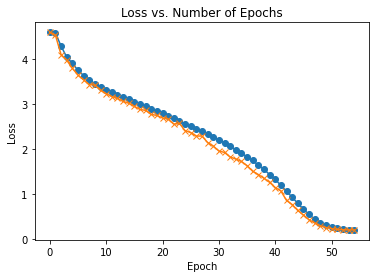

In [23]:
plot_losses(history[1:])

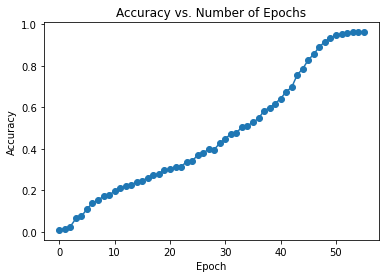

In [24]:
plot_accuracies(history)

In [25]:
for param in net.state_dict():
  print(param, '\t', net.state_dict()[param].size())

fc1.weight 	 torch.Size([1024, 3072])
fc1.bias 	 torch.Size([1024])
fc2.weight 	 torch.Size([512, 1024])
fc2.bias 	 torch.Size([512])
fc3.weight 	 torch.Size([256, 512])
fc3.bias 	 torch.Size([256])
fc4.weight 	 torch.Size([128, 256])
fc4.bias 	 torch.Size([128])
fc5.weight 	 torch.Size([100, 128])
fc5.bias 	 torch.Size([100])


In [26]:
PATH_MODEL = './cifar_net_test_version_model.pth'
torch.save(net, PATH_MODEL)

In [27]:
net = torch.load(PATH_MODEL)
net

Net(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=100, bias=True)
)

In [28]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

Ground Truth:  wardrobe lawn_mower television pear television mountain girl poppy
Predicted:  wardrobe lawn_mower television pear television mountain girl poppy


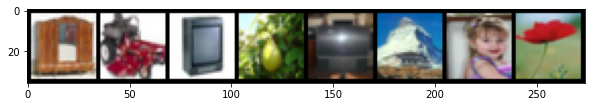

In [29]:
net.eval()
outputs = net(images)
_, predicted = torch.max(outputs, 1)
imgs = make_grid(images)
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('Ground Truth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))
print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

In [30]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])
print(f'Accuracy: {(gt == pred).sum() / len(gt)}')

Accuracy: 1.0
